<h1 style="font-family:verdana;"> <center>🛍 OTTO – Multi-Objective Recommender System - Getting Started 🧑‍💻</center> </h1>

***

### Citation

Andreas Wand, Philipp Normann, Sophie Baumeister, Timo Wilm, Walter Reade, and Maggie Demkin. OTTO – Multi-Objective Recommender System. https://kaggle.com/competitions/otto-recommender-system, 2022. Kaggle.

### License

This Notebook has been released under the Apache 2.0 open source license.

Original notebook by Edward Crookenden on Kaggle: [link](https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline/notebook).

Modified notebook by cuffyluv: https://github.com/cuffyluv

### <span style="font-family:verdana; word-spacing:1.5px;"> Contents:
[Load in the data ⏳](#first-bullet)
    
[Data Structure 🗂](#second-bullet)
    
[Intital EDA 📊](#third-bullet)
    
[Baseline 📈](#fourth-bullet)
    
[Where to go next 🚀](#fith-bullet)

### <span style="font-family:verdana; word-spacing:1.5px;">  Task overview
    
<span style="font-family:verdana; word-spacing:1.5px;">  The aim of this competition is to predict e-commerce <span style="color:#159364;">clicks, cart additions, and orders</span>. You'll build a multi-objective recommender system based on previous events in a user session.
    
<span style="font-family:verdana; word-spacing:1.5px;"> Current recommender systems consist of various models with different approaches, ranging from simple matrix factorization to a transformer-type deep neural network. However, no single model exists that can simultaneously optimize multiple objectives. In this competition, you’ll build a single entry to predict click-through, add-to-cart, and conversion rates based on previous same-session events.

### EDA 후기 by cuffyluv
1. 결측치와 중복값(중복 session field)를 체크하는 코드는 없네?
    
    1.1. 우리 대회 코드에는 있는 것과 대조적
2. 유저(세션) 기반과 아이템(aid) 기반으로 그 분포를 확인한 건 좋았다.
3. 세션 진행 시간도 분포를 내보긴 했지만, 이걸 나중에 모델 제작 시 사용할지는 모르겠다.
4. 예전에 다른 추천시스템 했던 노트북에서
5. 아직 세션 별 행동 순서는 분석해보진 않았네


### 모델 선택 by cuffyluv

- 세션 내 행동 순서가 중요함.
    - 클릭 하고 장바구니 담고 주문한 거랑, 바로 주문한 거는 선호도에서 후자가 더 높을 수 있음.
- 한 세션 당 길이가 그다지 길지 않음.
    - 대략 열 몇개 많아야 몇십 개 정도?
        - 이후 EDA 결과 세션 길이가 10 미만인 경우가 약 34.8%
    - 즉 transformer로 옮겨야 할 정도로 장기 의존성 문제가 심하진 않을 걸로 보임.
- 후보군: RNN, GRU, LSTM
    - 일단 세션 길이가 어느정도 되긴 하기에, RNN은 제외.
    - 일단 빠른 학습을 위해 GRU만으로 계산해 보자.
- GRU 사용
    - 후 추가 성능 개선 필요 시 LSTM 적용
- GRU를 쓴다면, 입력은??
    - 아래와 같은 식으로 해서 행렬로 concat한 다음에 입력에 넣으면 될듯.
    - aid_seq = [101, 102, 201, 103, 203]       # 실제 상품 ID
    - action_seq = [0, 0, 2, 0, 2]              # click=0, cart=1, order=2

### <span style="font-family:verdana; word-spacing:1.5px;">   Imports / setup 🚚

In [1]:
### Imports ###

import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')


In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/naver-boostcamp-ai-tech-8th/competition-study/week6

/content/drive/MyDrive/naver-boostcamp-ai-tech-8th/competition-study/week6


In [4]:
### Paths ###
DATA_PATH = Path('./input')
TRAIN_PATH = DATA_PATH/'train.jsonl'
TEST_PATH = DATA_PATH/'test.jsonl'
SAMPLE_SUB_PATH = DATA_PATH/'sample_submission.csv'

### 여담) pathlib.Path() vs os.path()
- pathlib.Path()를 사용하자.
- https://smecsm.tistory.com/259
- https://velog.io/@chlrbtlr30/Python-os.path%EC%99%80-pathlib

# <span style="font-family:verdana; word-spacing:1.5px;">   Load in the data ⏳

In [5]:
# Lets check how many lines the training data has!

# with open(TRAIN_PATH, 'r') as f:
#     print(f"We have {len(f.readlines()):,} lines in the training data")

# 12,899,779

# from tqdm import tqdm

# line_count = 0
# with open(TRAIN_PATH, 'r') as f:
#     for _ in tqdm(f, desc="Counting lines"):
#         line_count += 1

# print(f"We have {line_count:,} lines in the training data")

In [6]:
# !wc -l "input/train.jsonl"

In [7]:
# Load in a sample to a pandas df

sample_size = 150000

# 나눠서 읽겠다.
chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break
    # 우리는 chunk 하나만 EDA로 볼 거니까 바로 break 걸어버림.

# 여기서, chunks는 iterator이기 때문에, 우리가 TRAIN_PATH의 데이터를 다 메모리에 불러온 상태가 아님.
# 실제 그게 읽힐 때에 메모리에 올라감.

이때 각 줄(JSON 객체)은 Python 객체로 변환됨:

    JSON 배열 [...] → Python list
    JSON 객체 {...} → Python dict
    숫자, 문자열 등 → Python 타입 그대로

In [8]:
sample_train_df.set_index('session', drop=True, inplace=True)
# 'session' -> 어떤 컬럼을 인덱스로 쓸지 지정
# drop=True -> 원래 컬럼(session)은 삭제하고 인덱스로만 사용
# inplace=True -> 원본 DataFrame을 바로 수정
sample_train_df.head()

events
session                                                   
0        [{'aid': 1517085, 'ts': 1659304800025, 'type':...
1        [{'aid': 424964, 'ts': 1659304800025, 'type': ...
2        [{'aid': 763743, 'ts': 1659304800038, 'type': ...
3        [{'aid': 1425967, 'ts': 1659304800095, 'type':...
4        [{'aid': 613619, 'ts': 1659304800119, 'type': ...

In [9]:
sample_train_df

events
session                                                   
0        [{'aid': 1517085, 'ts': 1659304800025, 'type':...
1        [{'aid': 424964, 'ts': 1659304800025, 'type': ...
2        [{'aid': 763743, 'ts': 1659304800038, 'type': ...
3        [{'aid': 1425967, 'ts': 1659304800095, 'type':...
4        [{'aid': 613619, 'ts': 1659304800119, 'type': ...
...                                                    ...
149995   [{'aid': 443027, 'ts': 1659332465408, 'type': ...
149996   [{'aid': 1849006, 'ts': 1659332465484, 'type':...
149997   [{'aid': 135905, 'ts': 1659332465575, 'type': ...
149998   [{'aid': 288928, 'ts': 1659332465804, 'type': ...
149999   [{'aid': 1752139, 'ts': 1659332465811, 'type':...

[150000 rows x 1 columns]

# <span style="font-family:verdana; word-spacing:1.5px;">   Data structure 🗂
    
<span style="font-family:verdana; word-spacing:1.5px;">  `session` - the unique session id. Each session contains a list of time ordered events.

<span style="font-family:verdana; word-spacing:1.5px;">  `events` - the time ordered sequence of events in the session. Each event contains 3 pieces of information:

- <span style="font-family:verdana; word-spacing:1.5px;">  `aid` - the article id (product code) of the associated event
    
- <span style="font-family:verdana; word-spacing:1.5px;">  `ts` - the Unix timestamp of the event (Unix time is the number of **milliseconds** that have elapsed since 00:00:00 UTC on 1 January 1970) (Thanks to Junji Takeshima https://www.kaggle.com/junjitakeshima for the correction)

- <span style="font-family:verdana; word-spacing:1.5px;">  `type` - the event type, i.e., whether a product was clicked (`clicks`), added to the user's cart (`carts`), or ordered during the session (`orders`)


In [10]:
# Let's look at an example session and print out some basic info

# Sample the first session in the df
example_session = sample_train_df.iloc[0].item() # -> List(Dict)
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
# 사람이 보기 좋은 시간 형식으로 변환
print(f'The first session elapsed(경과함): {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
# 세션별 각 이벤트 종류 빈도 수 계산해서 출력함
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
print(f'The first session contains the following frequency of actions: {action_counts}')

This session was 276 actions long 

The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed(경과함): 27 days, 13:09:43.682000 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


In [11]:
print(type(sample_train_df.iloc[0].item()))
print('====================')
print(type(sample_train_df.iloc[0])) # Series
print('====================')
print(sample_train_df.iloc[0].item())
print('====================')
print(sample_train_df.iloc[0])
print('====================')
print(sample_train_df.iloc[0]['events'])
print(type(sample_train_df.iloc[0]['events'])) # List(Dict)
print('====================')

<class 'list'>
<class 'pandas.core.series.Series'>
[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'}, {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'}, {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'}, {'aid': 1110941, 'ts': 1659371104329, 'type': 

# <span style="font-family:verdana; word-spacing:1.5px;"> Intital EDA 📊

In [12]:
### Extract information from each session and add it to the df ###
# action_counts_list -> 세션별 행동 타입 개수(clicks, carts, orders)
# article_id_counts_list -> 세션별 상품별 등장 횟수
# session_length_time_list -> 세션 지속 시간(ms)
# session_length_action_list -> 세션 내 이벤트 수
action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {} # 전체 샘플에서 행동 타입 합산
overall_article_id_counts = {} # 전체 샘플에서 article_id 등장 횟수 합산

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    # iterrows()로 (index, series) 튜플 iterator 뽑아내서 그거 하나씩 가져온 것
    actions = row['events'] # List(Dict)

    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1

    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']

    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))

sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

In [13]:
sample_train_df

events  \
session                                                      
0        [{'aid': 1517085, 'ts': 1659304800025, 'type':...   
1        [{'aid': 424964, 'ts': 1659304800025, 'type': ...   
2        [{'aid': 763743, 'ts': 1659304800038, 'type': ...   
3        [{'aid': 1425967, 'ts': 1659304800095, 'type':...   
4        [{'aid': 613619, 'ts': 1659304800119, 'type': ...   
...                                                    ...   
149995   [{'aid': 443027, 'ts': 1659332465408, 'type': ...   
149996   [{'aid': 1849006, 'ts': 1659332465484, 'type':...   
149997   [{'aid': 135905, 'ts': 1659332465575, 'type': ...   
149998   [{'aid': 288928, 'ts': 1659332465804, 'type': ...   
149999   [{'aid': 1752139, 'ts': 1659332465811, 'type':...   

                                     action_counts  \
session                                              
0        {'clicks': 255, 'carts': 17, 'orders': 4}   
1                       {'carts': 8, 'clicks': 24}   
2                       {'clicks': 32, 'carts': 1}   
3        {'carts': 21, 'clicks': 200, 'orders': 5}   
4          {'clicks': 15, 'orders': 1, 'carts': 3}   
...                                            ...   
149995                               {'clicks': 2}   
149996                             {'clicks': 102}   
149997                              {'clicks': 35}   
149998                               {'clicks': 2}   
149999                               {'clicks': 4}   

                                         article_id_counts  \
session                                                      
0        {1517085: 1, 1563459: 1, 1309446: 1, 16246: 1,...   
1        {424964: 2, 1492293: 2, 910862: 2, 1491172: 2,...   
2        {763743: 1, 137492: 2, 504789: 1, 795863: 2, 3...   
3        {1425967: 6, 1343406: 14, 1815570: 1, 287008: ...   
4        {613619: 1, 298827: 2, 383828: 2, 255379: 2, 1...   
...                                                    ...   
149995                             {443027: 1, 1307228: 1}   
149996   {1849006: 1, 730780: 2, 380958: 1, 1233996: 1,...   
149997   {135905: 1, 475292: 2, 891341: 2, 1130018: 1, ...   
149998                              {288928: 1, 752186: 1}   
149999      {1752139: 1, 276163: 1, 1617030: 1, 674554: 1}   

         session_length_unix  session_length_hours  session_length_action  
session                                                                    
0                 2380183682            661.162663                    276  
1                 2410054967            669.460249                     32  
2                 2409415621            669.282652                     33  
3                 1804866676            501.352256                    226  
4                 2281881184            633.856392                     19  
...                      ...                   ...                    ...  
149995                147008              0.040836                      2  
149996            2303119022            639.755796                    102  
149997            2032976765            564.716220                     35  
149998                124409              0.034558                      2  
149999             800209694            222.280648                      4  

[150000 rows x 6 columns]

In [14]:
print(overall_action_counts)
print(overall_article_id_counts)

{'clicks': 7121618, 'carts': 565237, 'orders': 154972}
{1517085: 5, 1563459: 3, 1309446: 214, 16246: 64, 1781822: 1, 1152674: 2, 1649869: 41, 461689: 310, 305831: 127, 362233: 22, 984597: 4, 803544: 744, 1110941: 3, 1190046: 92, 1760685: 19, 631008: 61, 1650637: 249, 313546: 201, 979517: 96, 351157: 137, 1062149: 10, 1157384: 1, 1841388: 46, 1469630: 530, 1110548: 500, 1650114: 280, 1604396: 60, 1009750: 13, 1800933: 69, 495779: 385, 394655: 884, 789245: 143, 366890: 64, 361317: 30, 1700164: 304, 1755597: 38, 784978: 163, 1171505: 160, 1521766: 84, 1725503: 26, 528847: 95, 1816325: 115, 1072782: 288, 173702: 34, 1407538: 37, 1629651: 103, 1768568: 218, 1318324: 31, 1840418: 691, 1813509: 398, 667924: 751, 1226444: 335, 709550: 146, 709417: 144, 1225559: 91, 1048044: 25, 1052813: 18, 240346: 21, 1582117: 71, 1707783: 18, 1624436: 1085, 1157411: 425, 358305: 14, 1202970: 30, 832192: 4323, 1498443: 2527, 723931: 326, 1436439: 287, 1693461: 662, 1206554: 18, 1110741: 6, 346352: 1, 1802050:

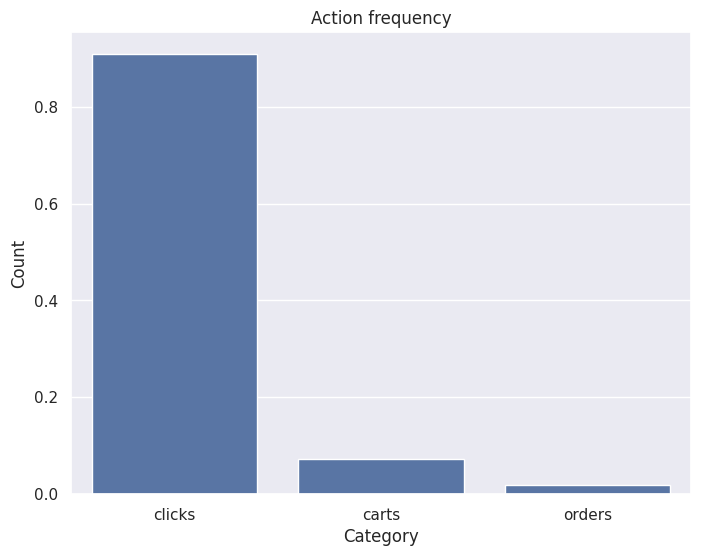

In [15]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

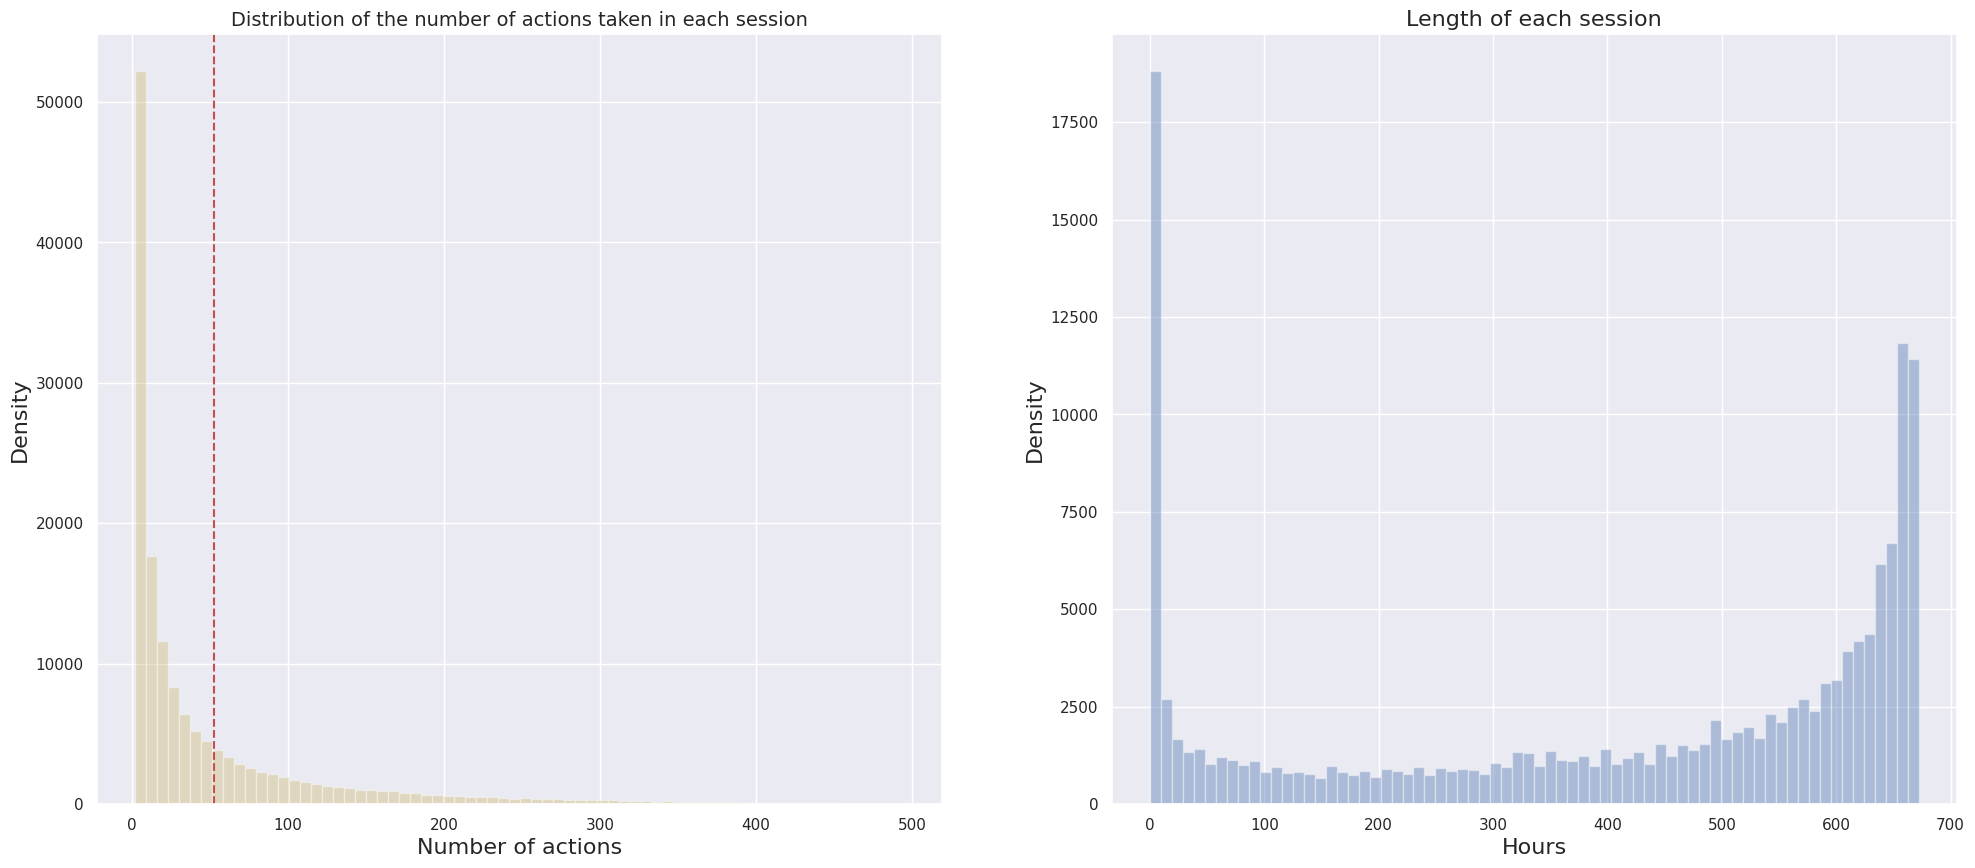

In [16]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

# 세션 내 액션 수(길이) 분포
p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

# 세션 지속 시간 분포
p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

Something seems a bit odd with the minutes plot. All the sessions are capped at 650 hours - this needs looking into .. 🤔

In [17]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')
# round(..., 3) * 100 -> 소수점 3자리까지 반올림 후 백분율로 변환

34.8% of the sessions had less than 10 actions


[5, 3, 214, 64, 1, 2, 41, 310, 127, 22]
830140
[5000, 4503, 4323, 4259, 3877, 3780, 3455, 3412, 3255, 3157]
830140
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
782612


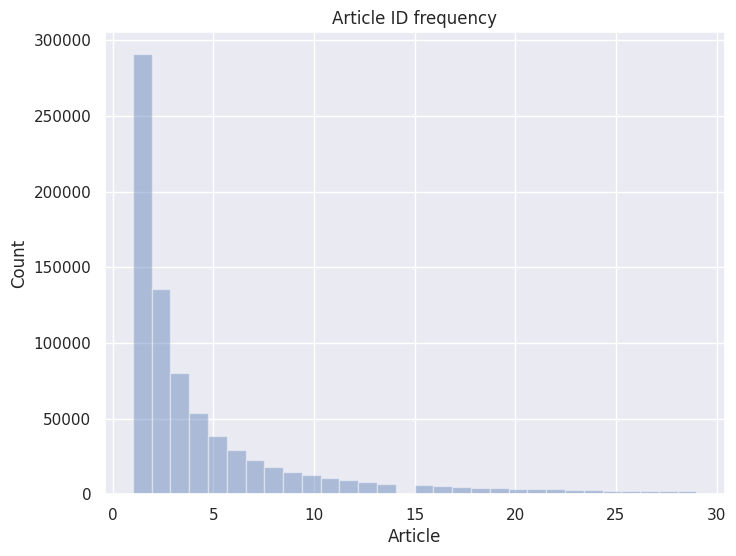

In [40]:
article_id_freq = list(overall_article_id_counts.values())
print(article_id_freq[:10])
print(len(article_id_freq))
article_id_freq.sort(reverse=True)
print(article_id_freq[:10])
print(len(article_id_freq))

cut_off = [i for i in article_id_freq if i<30]
print(cut_off[:10])
print(len(cut_off))

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

[5, 3, 214, 64, 1, 2, 41, 310, 127, 22]
830140
[5, 3, 1, 2, 22, 4, 3, 19, 10, 1]
782612


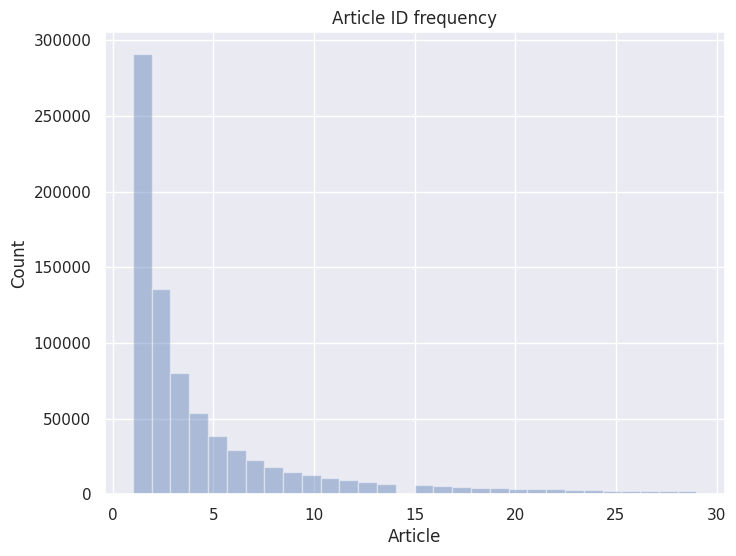

In [18]:
article_id_freq = list(overall_article_id_counts.values())
print(article_id_freq[:10])
print(len(article_id_freq))

cut_off = [i for i in article_id_freq if i<30]
print(cut_off[:10])
print(len(cut_off))

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

As we can see from the plot above the vast majority of atricles have a very small number of actions relating to them. There are some exceptions..

In [19]:
### Look at the most interacted with articles ###
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get) # heapq 모듈에 있음.
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


In [20]:
# 음 사실 딕셔너리 key, value 동시에 출력하는 거니까, 이렇게 items() 써서 튜플로 뽑아 하면 더 쉬움.
top_5 = nlargest(5, overall_article_id_counts.items(), key=lambda x: x[1])
print("Top 5 article_id with counts:", top_5)

Top 5 article_id with counts: [(29735, 5000), (1603001, 4503), (832192, 4323), (1733943, 4259), (108125, 3877)]


이제 추가적인 EDA를 해보자.

In [21]:
for length in range(0, 10):  # 0~9
    count = len(sample_train_df[sample_train_df['session_length_action'] == length])
    print(f"세션 길이 {length}인 세션 수: {count}")

세션 길이 0인 세션 수: 0
세션 길이 1인 세션 수: 0
세션 길이 2인 세션 수: 12586
세션 길이 3인 세션 수: 9344
세션 길이 4인 세션 수: 7383
세션 길이 5인 세션 수: 5969
세션 길이 6인 세션 수: 5131
세션 길이 7인 세션 수: 4372
세션 길이 8인 세션 수: 3973
세션 길이 9인 세션 수: 3455


아까 세션 길이 10 미만이 34.8%라고 한 것대로, 실제로 세션 길이가 짧은 것들이 많네.

In [22]:
mean_length = sample_train_df['session_length_action'].mean()
print(f"세션 길이 평균: {mean_length}")

세션 길이 평균: 52.27884666666667


일부 outlier들이 long-tail 분포를 이루면서 평균을 끌어오르고 있네.

# <span style="font-family:verdana; word-spacing:1.5px;">   Baseline 📈
    
<span style="font-family:verdana; word-spacing:1.5px;"> The `test data` contains truncated session data similar to that of the training data. The task is to <span style="color:#159364;"> predict the next aid clicked </span> after the session truncation, as well as the the remaining aids that are added to carts and orders; you may predict up to 20 values for each session type
    
<span style="font-family:verdana; word-spacing:1.5px;"> Submissions are evaluated on <span style="color:#159364;"> Recall </span> each action type, and the three recall values are weight-averaged: <span style="color:#159364;"> {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60} </span>. It is important to get the 'orders' predictions correct as they carry most of the weigthing :)
    
<span style="font-family:verdana; word-spacing:1.5px;"> For each <span style="color:#159364;"> session</span> in the test data, your task it to predict the <span style="color:#159364;"> aid</span> values for each <span style="color:#159364;"> type</span> that occur after the last timestamp ts the test session. In other words, the test data contains sessions truncated by timestamp, and you are to predict what occurs after the point of truncation.

<span style="font-family:verdana; word-spacing:1.5px;"> For <span style="color:#159364;"> clicks </span>there is only a single ground truth value for each session, which is the next <span style="color:#159364;"> aid</span> clicked during the session (although you can still predict up to 20 aid values). The ground truth for <span style="color:#159364;"> carts</span> and <span style="color:#159364;"> orders</span> contains all <span style="color:#159364;"> aid </span>values that were added to a cart and ordered respectively during the session.
    
Each session and type combination should appear on its own session_type row in the submission (3 rows per session), and predictions should be space delimited. This can be seen in the `sample_test_df` below..

In [23]:
# with open(TEST_PATH, 'r') as f:
#     print(f"We have {len(f.readlines()):,} lines in the test data")
# 1,671,803

In [24]:
# Load in a sample to a pandas df

sample_size = 150

chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

In [25]:
sample_test_df.head()

session                                             events
0  12899779  [{'aid': 59625, 'ts': 1661724000278, 'type': '...
1  12899780  [{'aid': 1142000, 'ts': 1661724000378, 'type':...
2  12899781  [{'aid': 141736, 'ts': 1661724000559, 'type': ...
3  12899782  [{'aid': 1669402, 'ts': 1661724000568, 'type':...
4  12899783  [{'aid': 255297, 'ts': 1661724000572, 'type': ...

In [26]:
sample_test_df.iloc[0]['events']

[{'aid': 59625, 'ts': 1661724000278, 'type': 'clicks'}]

### 추가적인 분석

<span style="font-family:verdana; word-spacing:1.5px;"> Below shows a sample submission. For each `session` in the test set there is a prediction (`labels`). This predicts what articles will be next interacted with in that session. For each session there are three actions (clicks, carts, orders), predictions are made for all three actions.

In [27]:
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission.head()

session_type                labels
0  12899779_clicks  129004 126836 118524
1   12899779_carts  129004 126836 118524
2  12899779_orders  129004 126836 118524
3  12899780_clicks  129004 126836 118524
4   12899780_carts  129004 126836 118524

<span style="font-family:verdana; word-spacing:1.5px;"> Lets find the most common article for each different type of action.

In [28]:
sample_size = 10_000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in enumerate(chunks):

    # Save time by not using all the data
    if e > 2:
        break

    sample_train_df = c

    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])


In [29]:
# Create dictionaries with articles and their frequencies
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [30]:
# Get the 20 most frequent articles for each action
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get)

In [31]:
# Create a dict with this info
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [32]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][:5]}') # Correction by @danielliao 🙏

Most frequent articles for clicks: [29735, 108125, 832192, 1733943, 1603001]
Most frequent articles for carts: [485256, 832192, 1733943, 166037, 29735]
Most frequent articles for order: [80222, 166037, 1022566, 1083665, 1733943]


<span style="font-family:verdana; word-spacing:1.5px;"> There is some overlap but the articles do change for the different actions!
    
<span style="font-family:verdana; word-spacing:1.5px;"> This baseline will use the fact that people will often interact with articles they have previouslt interacted with. The prediction will consist of the top 20 most frequent articles in the session. If there are less than 20 articles in the session the prediction will be padded with the most frequent articles in the training data as found above.

- 기준 1: 세션 내 과거 행동
    - 내 세션에서 가장 많이 나온 아이템 우선 추천
- 기준 2: 전체 학습 데이터에서 인기 아이템으로 패딩

In [33]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)

preds = []

for chunk in tqdm(test_data, total=1671):

    for i, row in chunk.iterrows():
        actions = row['events']
        article_id_list = []
        for action in actions:
            article_id_list.append(action['aid'])

        # Get 20 most common article ID for the session
        article_freq = Counter(article_id_list)
        top_articles = nlargest(20, article_freq, key = article_freq.get)

        # Pad with most popular items in training
        padding_size = (20 - len(top_articles)) # Correction by @danielliao 🙏
        for action in ['clicks', 'carts', 'order']:
            top_articles_added = top_articles + frequent_articles[action][:padding_size] # Correction by @danielliao 🙏
            preds.append(" ".join([str(id) for id in top_articles_added]))

  0%|          | 0/1671 [00:00<?, ?it/s]

In [34]:
# Predict the 20 most common atricles for each test session
sample_submission['labels'] = preds

In [35]:
print(os.getcwd())

/content/drive/MyDrive/naver-boostcamp-ai-tech-8th/competition-study/week6


In [36]:
sample_submission.to_csv('submission.csv', index=False)

In [37]:
sample_submission.head()

session_type                                             labels
0  12899779_clicks  59625 29735 108125 832192 1733943 1603001 1743...
1   12899779_carts  59625 485256 832192 1733943 166037 29735 14984...
2  12899779_orders  59625 80222 166037 1022566 1083665 1733943 160...
3  12899780_clicks  1142000 582732 973453 736515 29735 108125 8321...
4   12899780_carts  1142000 582732 973453 736515 485256 832192 173...

# Where to go next 🚀

- At the moment we pad every prediction with the same most frequently occuring articles. The model could be improved if we looked at which articles co-occured frequently in the same session ([KJ](https://www.kaggle.com/code/whitelily/co-occurrence-baseline) and [VLADIMIR SLAYKOVSKIY](https://www.kaggle.com/code/vslaykovsky/co-visitation-matrix) have started looking at this).

- While shopping there is a common sequence of events: click -> cart -> order. Currently we look at which articles are most common for each action but surely the most likely item to be ordered is one already in the cart 🤔
